In [14]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

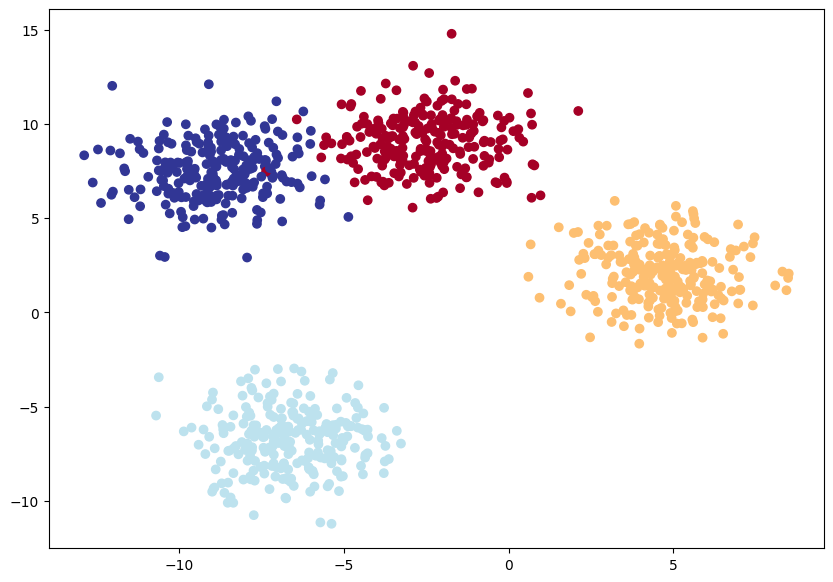

In [15]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shakeup
                            random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
# build model
class BlobModel(torch.nn.Module):
    def __init__(self, input_features:int, output_features:int, hidden_units:int=8):
        super().__init__()
        self.linear_layer_stack = torch.nn.Sequential(
            torch.nn.Linear(in_features=input_features,out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

In [18]:
print(X_blob_train.shape, y_blob_train.shape)
print(y_blob_train.unique())

torch.Size([800, 2]) torch.Size([800])
tensor([0, 1, 2, 3])


In [19]:
# instantiate model
model = BlobModel(input_features=2, # because there are 2 number of features of X(from X_blob_train.shape)
                  output_features=4, # because we have 4 classes(from y_blob_train.unique())
                  hidden_units=8)
model.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [20]:
# loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [21]:
# check model's raw output
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [22]:
# in order to evaluate, train and test model, we need to convert our model's raw output(logits)
# to prediction probabilities and then to prediction labels
# logits -> pred probs -> pred labels

# convert model's logit output to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) # use softmax activation to get prediction probabilities

# compare y_logits to y_pred_probs
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [23]:
# convert model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1) # use argmax(see docs) to get prediction labels

# compare to y_blob_test
y_preds[:10], y_blob_test[:10]

(tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

In [24]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [25]:
y_blob_train[:4], y_logits[:4]

(tensor([1, 0, 2, 2]),
 tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963]]))

In [26]:
# creating training and testing loop
torch.manual_seed(42)

epochs = 100

# move data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# loop
for epoch in range(epochs):
    model.train()

    y_logits = model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test Loss: 1.0755, Test Acc 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test Loss: 0.6607, Test Acc 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test Loss: 0.4307, Test Acc 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test Loss: 0.2451, Test Acc 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test Loss: 0.1023, Test Acc 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test Loss: 0.0585, Test Acc 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test Loss: 0.0429, Test Acc 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test Loss: 0.0349, Test Acc 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test Loss: 0.0299, Test Acc 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test Loss: 0.0266, Test Acc 99.50%


In [29]:
# evaluate
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

# go from logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# go from prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)


tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [30]:
# get helper file
# !wget "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://raw.githubusercontent.]87Saving 'helper_functions.py'
87helper_functions.py  100% [=============================>]    3.50K    --.-KB/s87HTTP response 200  [https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py]
87helper_functions.py  100% [=============================>]    3.50K    --.-KB/s87[Files: 1  Bytes: 3.50K [29.93K]8

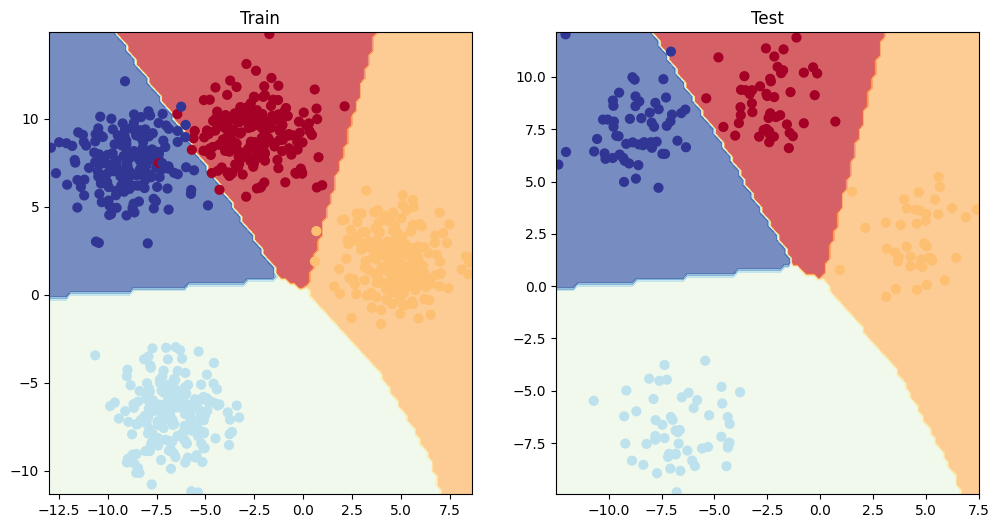

In [32]:
# import from helper file downloaded above
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

### A few more classification metrics

- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix
- Classification Report

Also check https://lightning.ai/docs/torchmetrics/stable/